In [311]:
# Imports
import pandas as pd
import json, ast
import matplotlib.pyplot as plt

In [312]:
# Functions

def parse_json_column(series: pd.Series):
    """Parse a column of JSON-like strings into a normalized DataFrame."""

    is_nested = False

    def parse_one(s):
        if pd.isna(s):
            return None
        if isinstance(s, (dict, list)):
            return s
        s = str(s).strip()
        if not s:
            return None
        try:
            return json.loads(s)
        except Exception:
            try:
                return ast.literal_eval(s)
            except Exception:
                return None

    records = []
    for s in series:
        obj = parse_one(s)
        if isinstance(obj, dict):
            # normalize: one dict = one row
            records.append(obj)
        elif isinstance(obj, list):
            # explode: each dict inside list becomes its own row
            is_nested = True
            for item in obj:
                if isinstance(item, dict):
                    records.append(item)

    return pd.DataFrame.from_records(records), is_nested


def get_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a DataFrame with counts of missing values for each column.
    Works for both DataFrame and Series.
    """
    if isinstance(df, pd.Series):
        missing_values = df.isnull().sum()
        return pd.DataFrame({
            "Column": [df.name],
            "Missing Count": [missing_values]
        })
    else:  # DataFrame
        missing_values = df.isnull().sum()
        return pd.DataFrame({
            "Column": missing_values.index,
            "Missing Count": missing_values.values
        })


def verify_subset(df_small: pd.DataFrame, df_large: pd.DataFrame, on=None) -> bool:
    """Check if all rows in df_small exist in df_large."""
    if on is None:
        merged = df_small.merge(df_large.drop_duplicates(), how="left", indicator=True)
    else:
        merged = df_small[on].merge(df_large[on].drop_duplicates(), how="left", indicator=True)
    return merged["_merge"].eq("left_only").sum() == 0


def get_missing_rows(df_small: pd.DataFrame, df_large: pd.DataFrame, on=None) -> pd.DataFrame:
    """Return rows from df_small that do not exist in df_large."""
    if on is None:
        merged = df_small.merge(df_large.drop_duplicates(), how="left", indicator=True)
    else:
        merged = df_small[on].merge(df_large[on].drop_duplicates(), how="left", indicator=True)
    return merged[merged["_merge"] == "left_only"].drop(columns="_merge")

# Part 1: Exploratory Data Analysis

---
## Dataset: credits.csv

##### Data exploration

In [313]:
df_credits = pd.read_csv("movies/credits.csv")
df_credits

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862
...,...,...,...
45471,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050
45472,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109
45473,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758
45474,"[{'cast_id': 2, 'character': '', 'credit_id': ...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506


In [314]:
# Size
print("Size:", len(df_credits))

Size: 45476


In [315]:
# Data types of each column
df_credits.dtypes

cast    object
crew    object
id       int64
dtype: object

##### Missing values

In [316]:
df_credits_missing = get_missing_values(df_credits)
df_credits_missing

,Column,Missing Count
0,cast,0
1,crew,0
2,id,0


### Column cast

In [317]:
df_credits_cast, is_nested = parse_json_column(df_credits['cast'])
print("Nested:", is_nested)
df_credits_cast

Nested: True


,cast_id,character,credit_id,gender,id,name,order,profile_path
0,14,Woody (voice),52fe4284c3a36847f8024f95,2,31,Tom Hanks,0,/pQFoyx7rp09CJTAb932F2g8Nlho.jpg
1,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,12898,Tim Allen,1,/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg
2,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,7167,Don Rickles,2,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg
3,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,12899,Jim Varney,3,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg
4,18,Rex (voice),52fe4284c3a36847f8024fa5,2,12900,Wallace Shawn,4,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg
...,...,...,...,...,...,...,...,...
562469,2,,52fe4ea59251416c7515d7d5,2,544742,Iwan Mosschuchin,0,None
562470,3,,52fe4ea59251416c7515d7d9,1,1090923,Nathalie Lissenko,1,None
562471,4,,52fe4ea59251416c7515d7dd,2,1136422,Pavel Pavlov,2,None
562472,5,,52fe4ea59251416c7515d7e1,0,1261758,Aleksandr Chabrov,3,None


In [318]:
# Size
print("Size:", len(df_credits_cast))

Size: 562474


##### Missing values

In [319]:
df_credits_cast_missing = get_missing_values(df_credits_cast)
df_credits_cast_missing

,Column,Missing Count
0,cast_id,0
1,character,0
2,credit_id,0
3,gender,0
4,id,0
5,name,0
6,order,0
7,profile_path,173856


##### Unique values in column gender

In [320]:
print(f"Unique value in Gender: {df_credits_cast['gender'].unique()}")

Unique value in Gender: [2 1 0]


## Column crew

In [321]:
df_credits_crew, is_nested = parse_json_column(df_credits['crew'])
print("Nested:", is_nested)
df_credits_crew

Nested: True


,credit_id,department,gender,id,job,name,profile_path
0,52fe4284c3a36847f8024f49,Directing,2,7879,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg
1,52fe4284c3a36847f8024f4f,Writing,2,12891,Screenplay,Joss Whedon,/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg
2,52fe4284c3a36847f8024f55,Writing,2,7,Screenplay,Andrew Stanton,/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg
3,52fe4284c3a36847f8024f5b,Writing,2,12892,Screenplay,Joel Cohen,/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg
4,52fe4284c3a36847f8024f61,Writing,0,12893,Screenplay,Alec Sokolow,/v79vlRYi94BZUQnkkyznbGUZLjT.jpg
...,...,...,...,...,...,...,...
464309,52fe4776c3a368484e0c8399,Sound,0,549356,Original Music Composer,Richard McHugh,None
464310,52fe4776c3a368484e0c839f,Camera,2,58818,Director of Photography,João Fernandes,None
464311,533bccebc3a36844cf0011a7,Directing,0,1085341,Director,Yakov Protazanov,/yyjbGdCs2ZN6IlZNCfmBWyuRDlt.jpg
464312,58ebbc26925141281908aa0a,Production,2,1195656,Producer,Joseph N. Ermolieff,None


In [322]:
# Size
print("Size:", len(df_credits_crew))

Size: 464314


##### Missing values

In [323]:
df_credits_crew_missing = get_missing_values(df_credits_crew)
df_credits_crew_missing

,Column,Missing Count
0,credit_id,0
1,department,0
2,gender,0
3,id,0
4,job,0
5,name,0
6,profile_path,369216


##### Unique values in column department, job


In [324]:
relevant_cols = ['department', 'job']
for col in  relevant_cols:
    print(f"Unique values in {col}:\n {df_credits_crew[col].unique()}")

Unique values in department:
 ['Directing' 'Writing' 'Production' 'Editing' 'Art' 'Sound'
 'Visual Effects' 'Crew' 'Lighting' 'Camera' 'Costume & Make-Up' 'Actors']
Unique values in job:
 ['Director' 'Screenplay' 'Producer' 'Executive Producer' 'Editor'
 'Art Direction' 'Foley Editor' 'Animation' 'ADR Editor' 'Orchestrator'
 'Color Timer' 'CG Painter' 'Original Story' 'Post Production Supervisor'
 'Sculptor' 'Animation Director' 'Music' 'Layout' 'Music Editor'
 'Negative Cutter' 'Title Designer' 'Supervising Technical Director'
 'Songs' 'Supervising Animator' 'Sound Designer' 'Production Supervisor'
 'Executive Music Producer' 'Visual Effects Supervisor' 'Visual Effects'
 'Lighting Supervisor' 'Character Designer' 'Set Dresser'
 'Editorial Manager' 'Assistant Editor' 'Editorial Coordinator'
 'Production Coordinator' 'Unit Publicist' 'Sound Re-Recording Mixer'
 'Supervising Sound Editor' 'Sound Effects Editor'
 'Sound Design Assistant' 'Assistant Sound Editor' 'Casting Consultant'
 'ADR

In [325]:
for col in  relevant_cols:
    print(f"Count of unique values in {col}: {len(df_credits_crew[col].unique())}")

Count of unique values in department: 12
Count of unique values in job: 456


---
### Dataset: keywords.csv

##### Data exploration

In [326]:
df_keywords = pd.read_csv("movies/keywords.csv")
df_keywords

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...
46414,439050,"[{'id': 10703, 'name': 'tragic love'}]"
46415,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46416,67758,[]
46417,227506,[]


In [327]:
# Size
print("Size:", len(df_keywords))

Size: 46419


In [328]:
# Data types of each column
df_keywords.dtypes

id           int64
keywords    object
dtype: object

##### Missing values

In [329]:
# Counting occurrences of missing values
df_keywords_missing = get_missing_values(df_keywords)
df_keywords_missing

,Column,Missing Count
0,id,0
1,keywords,0


##### Duplicated values in column id

In [330]:
duplicate_count = df_keywords['id'].duplicated().sum()

print(f"Number of duplicate IDs: {duplicate_count}")

Number of duplicate IDs: 987


## Column keywords

In [331]:
df_keywords_keywords, is_nested = parse_json_column(df_keywords['keywords'])
print("Nested:", is_nested)
df_keywords_keywords

Nested: True


,id,name
0,931,jealousy
1,4290,toy
2,5202,boy
3,6054,friendship
4,9713,friends
...,...,...
158675,11800,mockumentary
158676,10703,tragic love
158677,2679,artist
158678,14531,play


In [332]:
df_keywords_keywords_missing = get_missing_values(df_keywords_keywords)
df_keywords_keywords_missing

,Column,Missing Count
0,id,0
1,name,0


In [333]:
# Size
print("Size:", len(df_keywords_keywords))

Size: 158680


##### Duplicated values in column id,  name

In [334]:
# relevant_cols = ['id', 'name']
# for col in  relevant_cols:
#     print(f"Duplicated values in {col}:\n {df_keywords_keywords[col].duplicated().sum()}")

---
### Dataset: links.csv

##### Data exploration

In [335]:
df_links = pd.read_csv("movies/links.csv")
df_links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
45838,176269,6209470,439050.0
45839,176271,2028550,111109.0
45840,176273,303758,67758.0
45841,176275,8536,227506.0


In [336]:
# Size
print("Size:", len(df_links))

Size: 45843


In [337]:
# Data types of each column
df_links.dtypes

movieId      int64
imdbId       int64
tmdbId     float64
dtype: object

##### Missing values

In [338]:
# Counting occurrences of missing values
df_links_missing = get_missing_values(df_links)
df_links_missing

,Column,Missing Count
0,movieId,0
1,imdbId,0
2,tmdbId,219


##### Duplicated values in column movieId, imdbId, tmdbId

In [339]:
relevant_cols = ['movieId', 'imdbId', 'tmdbId']
for col in  relevant_cols:
    print(f"Duplicated values in {col}:\n {df_links[col].duplicated().sum()}")

Duplicated values in movieId:
 0
Duplicated values in imdbId:
 0
Duplicated values in tmdbId:
 248


---
### Dataset: links_small.csv

##### Data exploration

In [340]:
df_links_small = pd.read_csv("movies/links_small.csv")
df_links_small

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9120,162672,3859980,402672.0
9121,163056,4262980,315011.0
9122,163949,2531318,391698.0
9123,164977,27660,137608.0


In [341]:
# Size
print("Size:", len(df_links))

Size: 45843


In [342]:
# Data types of each column
df_links_small.dtypes

movieId      int64
imdbId       int64
tmdbId     float64
dtype: object

##### Missing values

In [343]:
# Counting occurrences of missing values
df_links_small_missing = get_missing_values(df_links_small)
df_links_small_missing

,Column,Missing Count
0,movieId,0
1,imdbId,0
2,tmdbId,13


##### Duplicated values in column movieId, imdbId, tmdbId

In [344]:
relevant_cols = ['movieId', 'imdbId', 'tmdbId']
for col in  relevant_cols:
    print(f"Duplicated values in {col}:\n {df_links_small[col].duplicated().sum()}")

Duplicated values in movieId:
 0
Duplicated values in imdbId:
 0
Duplicated values in tmdbId:
 12


##### Verify that all df_links_small is consistent with df_links

In [345]:
verify_subset(df_links_small, df_links)

False

In [346]:
df_links_small_missing_rows = get_missing_rows(df_links_small, df_links)
df_links_small_missing_rows

,movieId,imdbId,tmdbId
5173,7502,185906,191903.0
7527,77658,81846,205300.0
8045,94466,2085059,NaN
8505,108548,898266,NaN
8507,108583,72500,NaN
8520,108979,213338,314040.0
9062,150856,5189670,374454.0
9118,162376,4574334,410612.0
9123,164977,27660,137608.0
9124,164979,3447228,410803.0


---
## Dataset: movies_metadata.csv

##### Data exploration

In [476]:
df_movies_metadata = pd.read_csv("movies/movies_metadata.csv")
df_movies_metadata

C:\Users\jensc\AppData\Local\Temp\ipykernel_19424\364127922.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies_metadata = pd.read_csv("movies/movies_metadata.csv")


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [348]:
# Data types of each column
df_movies_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

##### Missing values

In [349]:
# Counting occurrences of missing values
df_movies_metadata_missing = get_missing_values(df_movies_metadata)
df_movies_metadata_missing

,Column,Missing Count
0,adult,0
1,belongs_to_collection,40972
2,budget,0
3,genres,0
4,homepage,37684
5,id,0
6,imdb_id,17
7,original_language,11
8,original_title,0
9,overview,954


## Column adult

In [350]:
# Unique values in adult
df_movies_metadata_adult = df_movies_metadata['adult']
print(f"Unique values in adult: {df_movies_metadata_adult.unique()}")

Unique values in adult: ['False' 'True' ' - Written by Ørnås'
 ' Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.'
 ' Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.']


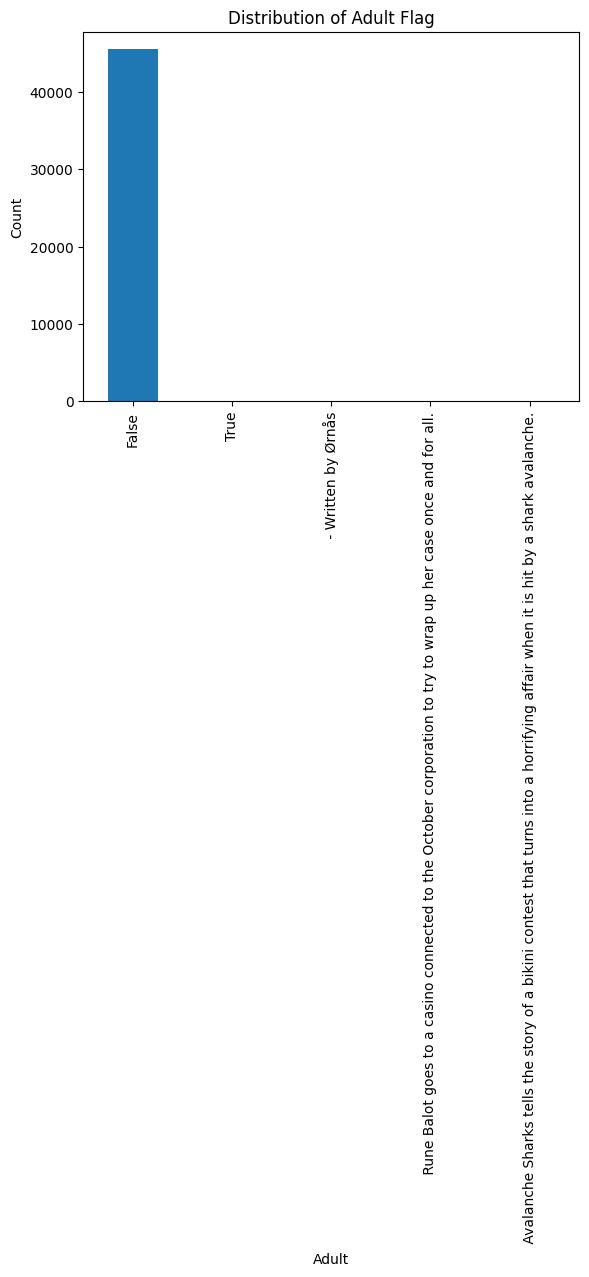

In [351]:
# Histogram plot
df_movies_metadata_adult.value_counts().plot(kind="bar")
plt.title("Distribution of Adult Flag")
plt.xlabel("Adult")
plt.ylabel("Count")
plt.show()

## Column belongs_to_collection

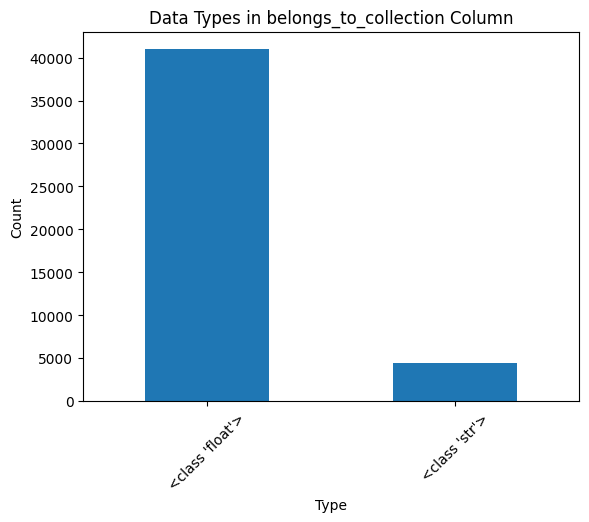

In [352]:
# Get type of each element
type_counts = df_movies_metadata['belongs_to_collection'].map(type).value_counts()

# Plot histogram of types
type_counts.plot(kind="bar")
plt.title("Data Types in belongs_to_collection Column")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [353]:
# Extract only the float values from the column
floats = df_movies_metadata['belongs_to_collection'][
    df_movies_metadata['belongs_to_collection'].apply(lambda x: isinstance(x, float))
]
floats.unique()

array([nan], dtype=object)

In [354]:
# Extract only the json values from the column
df_movies_metadata_belongs_to_collection = df_movies_metadata['belongs_to_collection'][
    df_movies_metadata['belongs_to_collection'].apply(lambda x: not isinstance(x, float))
]
df_movies_metadata_belongs_to_collection, is_nested = parse_json_column(df_movies_metadata_belongs_to_collection)
print("Nested:", is_nested)
df_movies_metadata_belongs_to_collection

Nested: False


,id,name,poster_path,backdrop_path
0,10194,Toy Story Collection,/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg,/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg
1,119050,Grumpy Old Men Collection,/nLvUdqgPgm3F85NMCii9gVFUcet.jpg,/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg
2,96871,Father of the Bride Collection,/nts4iOmNnq7GNicycMJ9pSAn204.jpg,/7qwE57OVZmMJChBpLEbJEmzUydk.jpg
3,645,James Bond Collection,/HORpg5CSkmeQlAolx3bKMrKgfi.jpg,/6VcVl48kNKvdXOZfJPdarlUGOsk.jpg
4,117693,Balto Collection,/w0ZgH6Lgxt2bQYnf1ss74UvYftm.jpg,/9VM5LiJV0bGb1st1KyHA3cVnO2G.jpg
...,...,...,...,...
4486,37261,The Carry On Collection,/2P0HNrYgKDvirV8RCdT1rBSJdbJ.jpg,/38tF1LJN7ULeZAuAfP7beaPMfcl.jpg
4487,37261,The Carry On Collection,/2P0HNrYgKDvirV8RCdT1rBSJdbJ.jpg,/38tF1LJN7ULeZAuAfP7beaPMfcl.jpg
4488,37261,The Carry On Collection,/2P0HNrYgKDvirV8RCdT1rBSJdbJ.jpg,/38tF1LJN7ULeZAuAfP7beaPMfcl.jpg
4489,477208,DC Super Hero Girls Collection,None,None


In [355]:
df_movies_metadata_belongs_to_collection.dtypes

id                int64
name             object
poster_path      object
backdrop_path    object
dtype: object

##### Missing values

In [356]:
df_movies_metadata_belongs_to_collection_missing = get_missing_values(df_movies_metadata_belongs_to_collection)
df_movies_metadata_belongs_to_collection_missing

,Column,Missing Count
0,id,0
1,name,0
2,poster_path,543
3,backdrop_path,1228


##### Duplicated values in id

In [357]:
print(f"Duplicated values in ID:\n {df_movies_metadata_belongs_to_collection['id'].duplicated().sum()}")

Duplicated values in ID:
 2796


## Column budget

In [358]:
df_movies_metadata['budget'] = pd.to_numeric(df_movies_metadata['budget'], errors='coerce')
df_movies_metadata = df_movies_metadata.dropna(subset=['budget'])
df_movies_metadata_budget = df_movies_metadata['budget'].astype('int64')
df_movies_metadata_budget

0        30000000
1        65000000
2               0
3        16000000
4               0
           ...   
45461           0
45462           0
45463           0
45464           0
45465           0
Name: budget, Length: 45463, dtype: int64

In [359]:
type_counts = df_movies_metadata['budget'].map(type).value_counts()
type_counts

budget
<class 'float'>    45463
Name: count, dtype: int64

In [360]:
# Size
size = df_movies_metadata_budget.count()
size

45463

In [361]:
# Count zero instances
zeros = df_movies_metadata_budget[df_movies_metadata['budget']==0].count()
print("Instances where the budget is zero:", zeros)

Instances where the budget is zero: 36573


In [362]:
# Percentage for zero in budget
print("Percentage zero:", round((zeros/size), 3))

Percentage zero: 0.804


In [363]:
# Count below zero instances
under_zeros = df_movies_metadata_budget[df_movies_metadata['budget']<0].count()
print("Instances where the budget is zero:", under_zeros)

Instances where the budget is zero: 0


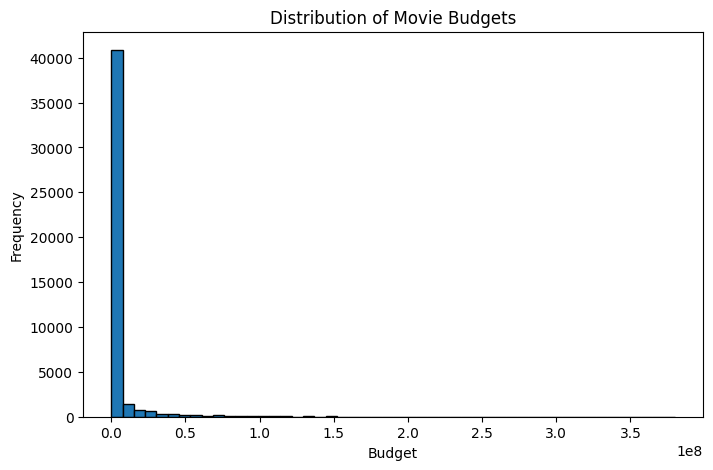

In [364]:
# Plot histogram of the budget column
plt.figure(figsize=(8, 5))
plt.hist(df_movies_metadata['budget'], bins=50, edgecolor='black')
plt.title('Distribution of Movie Budgets')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.show()

In [365]:
# 1. Parse 'belongs_to_collection' column
df_collections = parse_json_column(df_movies_metadata['belongs_to_collection'])
print("Nested:", is_nested)

# 2. Convert budget to numeric
df_movies_metadata['budget'] = pd.to_numeric(df_movies_metadata['budget'], errors='coerce')

# 3. Join collection 'name' back into main DataFrame
def extract_name(s):
    parsed, _ = parse_json_column(pd.Series([s]))
    if not parsed.empty and 'name' in parsed.columns:
        return parsed['name'].iloc[0]
    return None

df_movies_metadata['collection_name'] = df_movies_metadata['belongs_to_collection'].apply(extract_name)

# 4. Filter only budgets > 0
df_nonzero = df_movies_metadata[df_movies_metadata['budget'] > 0]

# 5. Top 5 and bottom 5 budgets
top5 = df_nonzero.nlargest(5, 'budget')[['budget', 'collection_name']]
bottom5 = df_nonzero.nsmallest(5, 'budget')[['budget', 'collection_name']]

print("Top 5 budgets:")
print(top5)

print("\nBottom 5 budgets:")
print(bottom5)


Nested: False


C:\Users\jensc\AppData\Local\Temp\ipykernel_19424\1989935115.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_metadata['budget'] = pd.to_numeric(df_movies_metadata['budget'], errors='coerce')


Top 5 budgets:
            budget                      collection_name
17124  380000000.0  Pirates of the Caribbean Collection
11827  300000000.0  Pirates of the Caribbean Collection
26558  280000000.0              The Avengers Collection
11067  270000000.0                  Superman Collection
16130  260000000.0                   Tangled Collection

Bottom 5 budgets:
      budget collection_name
922      1.0            None
2192     1.0            None
2483     1.0            None
3342     1.0            None
4000     1.0            None


C:\Users\jensc\AppData\Local\Temp\ipykernel_19424\1989935115.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_metadata['collection_name'] = df_movies_metadata['belongs_to_collection'].apply(extract_name)


## Column genres

In [366]:
df_movies_metadata_genres, is_nested = parse_json_column(df_movies_metadata['genres'])
print("Nested:", is_nested)
df_movies_metadata_genres

Nested: True


,id,name
0,16,Animation
1,35,Comedy
2,10751,Family
3,12,Adventure
4,14,Fantasy
...,...,...
91089,10751,Family
91090,18,Drama
91091,28,Action
91092,18,Drama


In [461]:
type_counts = df_movies_metadata_genres.map(type).value_counts()
type_counts

id             name         
<class 'int'>  <class 'str'>    91094
Name: count, dtype: int64

In [367]:
# Size
size = df_movies_metadata_budget.count()

##### # Unique values in column name

In [368]:

print(f"Unique value in name: {df_movies_metadata_genres['name'].unique()}")

Unique value in name: ['Animation' 'Comedy' 'Family' 'Adventure' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'History' 'Science Fiction'
 'Mystery' 'War' 'Foreign' 'Music' 'Documentary' 'Western' 'TV Movie']


In [369]:
print(f"Count of unique value in name: {len(df_movies_metadata_genres['name'].unique())}")

Count of unique value in name: 20


##### Duplicate values in column id

In [370]:
print(f"Duplicated values in ID:\n {df_movies_metadata_belongs_to_collection['id'].duplicated().sum()}")

Duplicated values in ID:
 2796


## Column homepage

In [477]:
df_movies_metadata['homepage'] = df_movies_metadata['homepage'].astype('string')
df_movies_metadata['homepage'] = df_movies_metadata['homepage'].fillna('')
df_movies_metadata_homepage = df_movies_metadata['homepage']
df_movies_metadata_homepage

0        http://toystory.disney.com/toy-story
1                                            
2                                            
3                                            
4                                            
                         ...                 
45461    http://www.imdb.com/title/tt6209470/
45462                                        
45463                                        
45464                                        
45465                                        
Name: homepage, Length: 45466, dtype: string

In [478]:
df_movies_metadata_homepage.dtypes

string[python]

In [479]:
type_counts = df_movies_metadata['homepage'].map(type).value_counts()
type_counts

homepage
<class 'str'>    45466
Name: count, dtype: int64

In [374]:
size = len(df_movies_metadata_homepage)
print("Size:", size)

Size: 45463


###### Missing values (NaN)

In [375]:
df_movies_metadata_homepage_missing = df_movies_metadata['homepage'].isna()
count_of_nan = df_movies_metadata_homepage_missing.sum()
print("Count of NaN:", count_of_nan)


Count of NaN: 37684


In [376]:
# Percentage
print("Percentage NaN", round(count_of_nan/size, 4))

Percentage NaN 0.8289


## Column id

In [377]:
df_movies_metadata_id = df_movies_metadata['id']
df_movies_metadata_id

0           862
1          8844
2         15602
3         31357
4         11862
          ...  
45461    439050
45462    111109
45463     67758
45464    227506
45465    461257
Name: id, Length: 45463, dtype: object

In [378]:
df_movies_metadata['id'] = pd.to_numeric(df_movies_metadata['id'], errors='coerce').astype('Int64')
df_movies_metadata['id']

C:\Users\jensc\AppData\Local\Temp\ipykernel_19424\1411043842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_metadata['id'] = pd.to_numeric(df_movies_metadata['id'], errors='coerce').astype('Int64')


0           862
1          8844
2         15602
3         31357
4         11862
          ...  
45461    439050
45462    111109
45463     67758
45464    227506
45465    461257
Name: id, Length: 45463, dtype: Int64

##### Duplicated values in id

In [480]:
print(f"Duplicated values in ID: {df_movies_metadata_id.duplicated().sum()}")


Duplicated values in ID: 30


In [380]:
type_counts = df_movies_metadata['id'].map(type).value_counts()
type_counts

id
<class 'int'>    45463
Name: count, dtype: int64

## Column imdb_id

In [381]:
df_movies_metadata_imdb_id =df_movies_metadata['imdb_id']
df_movies_metadata_imdb_id

0        tt0114709
1        tt0113497
2        tt0113228
3        tt0114885
4        tt0113041
           ...    
45461    tt6209470
45462    tt2028550
45463    tt0303758
45464    tt0008536
45465    tt6980792
Name: imdb_id, Length: 45463, dtype: object

In [483]:
# df_movies_metadata2 = df_movies_metadata[df_movies_metadata['imdb_id'].apply(lambda x: isinstance(x, str))]
# df_movies_metadata2 = df_movies_metadata2.reset_index(drop=True)
# df_movies_metadata_imdb_id = df_movies_metadata2['imdb_id']
# df_movies_metadata_imdb_id

0        tt0114709
1        tt0113497
2        tt0113228
3        tt0114885
4        tt0113041
           ...    
45444    tt6209470
45445    tt2028550
45446    tt0303758
45447    tt0008536
45448    tt6980792
Name: imdb_id, Length: 45449, dtype: object

In [485]:
type_counts = df_movies_metadata['imdb_id'].map(type).value_counts()
type_counts

imdb_id
<class 'str'>    45449
Name: count, dtype: int64

##### Duplicated values in imdb_id

In [384]:
print(f"Duplicated values in ID: {df_movies_metadata_imdb_id.duplicated().sum()}")

Duplicated values in ID: 46


## Column original_language

In [385]:
df_movies_metadata_original_language = df_movies_metadata['original_language']
df_movies_metadata_original_language

0        en
1        en
2        en
3        en
4        en
         ..
45461    fa
45462    tl
45463    en
45464    en
45465    en
Name: original_language, Length: 45463, dtype: object

In [486]:
type_counts = df_movies_metadata['original_language'].map(type).value_counts()
type_counts

original_language
<class 'str'>      45455
<class 'float'>       11
Name: count, dtype: int64

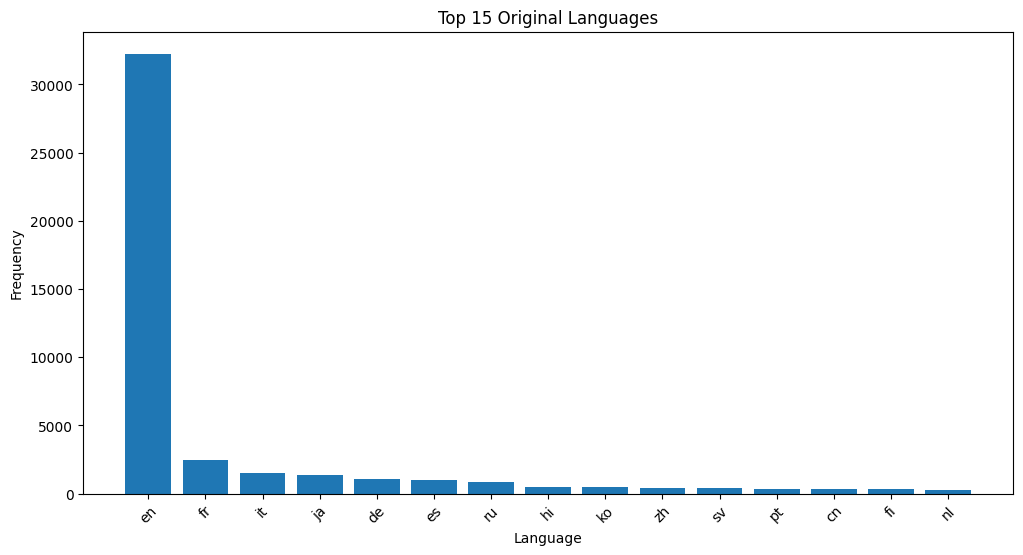

In [386]:
# Frequency of each language (top 15)
lang_freq = df_movies_metadata['original_language'].value_counts().head(15)

# Plot frequency diagram (top 15 languages)
plt.figure(figsize=(12,6))
plt.bar(lang_freq.index, lang_freq.values)
plt.title("Top 15 Original Languages")
plt.xlabel("Language")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [387]:
# Count of unique languages
print("Count of unique languages:", df_movies_metadata['original_language'].nunique())

Count of unique languages: 89


## Column original_title

In [388]:
df_movies_metadata_original_title = df_movies_metadata['original_title']
df_movies_metadata_original_title

0                          Toy Story
1                            Jumanji
2                   Grumpier Old Men
3                  Waiting to Exhale
4        Father of the Bride Part II
                    ...             
45461                        رگ خواب
45462            Siglo ng Pagluluwal
45463                       Betrayal
45464            Satana likuyushchiy
45465                       Queerama
Name: original_title, Length: 45463, dtype: object

In [487]:
type_counts = df_movies_metadata['original_title'].map(type).value_counts()
type_counts

original_title
<class 'str'>    45466
Name: count, dtype: int64

In [389]:
unique_original_title_values = df_movies_metadata['original_title'].unique()
print("Unique values in 'adult':", unique_original_title_values)

Unique values in 'adult': ['Toy Story' 'Jumanji' 'Grumpier Old Men' ... 'Siglo ng Pagluluwal'
 'Satana likuyushchiy' 'Queerama']


In [390]:
# Count of unique original titles
print("Count of original titles:", len(unique_original_title_values))

Count of original titles: 43371


##### Missing values

In [391]:
df_movies_metadata_original_title_missing = get_missing_values(df_movies_metadata['original_title'])
df_movies_metadata_original_title_missing

,Column,Missing Count
0,original_title,0


## Column overview

In [392]:
df_movies_metadata_overview = df_movies_metadata['overview']
df_movies_metadata_overview

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
45461          Rising and falling between a man and woman.
45462    An artist struggles to finish his work while a...
45463    When one of her hits goes wrong, a professiona...
45464    In a small town live two brothers, one a minis...
45465    50 years after decriminalisation of homosexual...
Name: overview, Length: 45463, dtype: object

In [393]:
df_movies_metadata_overview.dtypes

dtype('O')

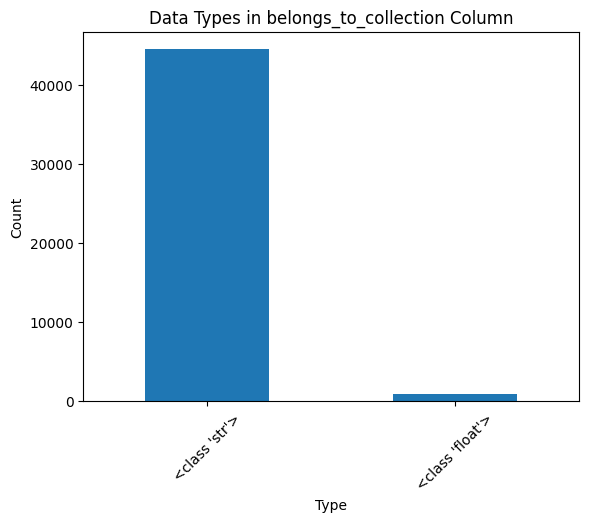

In [394]:
# Get type of each element
type_counts = df_movies_metadata_overview.map(type).value_counts()

# Plot histogram of types
type_counts.plot(kind="bar")
plt.title("Data Types in belongs_to_collection Column")
plt.xlabel("Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [395]:
unique_overview_values = df_movies_metadata['overview'].unique()
print("Count of original titles:", len(unique_overview_values))

Count of original titles: 44307


## Column popularity

In [396]:
df_movies_metadata_popularity = df_movies_metadata['popularity']
df_movies_metadata_popularity

0        21.946943
1        17.015539
2          11.7129
3         3.859495
4         8.387519
           ...    
45461     0.072051
45462     0.178241
45463     0.903007
45464     0.003503
45465     0.163015
Name: popularity, Length: 45463, dtype: object

In [489]:
# Separate rows where 'popularity' is a float
df_popularity_float = df_movies_metadata[df_movies_metadata['popularity'].apply(lambda x: isinstance(x, float))]

# Separate rows where 'popularity' is a string
df_popularity_string = df_movies_metadata[df_movies_metadata['popularity'].apply(lambda x: isinstance(x, str))]


In [497]:
df_popularity_float['popularity']

0        21.946943
1        17.015539
2          11.7129
3         3.859495
4         8.387519
           ...    
32764     0.214778
32765     2.774803
32766     0.910314
32767     0.923746
35586          NaN
Name: popularity, Length: 32769, dtype: object

In [496]:
df_popularity_string['popularity']

32768    0.837228
32769    7.350821
32770    0.244392
32771    0.215456
32772    1.208227
           ...   
45461    0.072051
45462    0.178241
45463    0.903007
45464    0.003503
45465    0.163015
Name: popularity, Length: 12697, dtype: object

In [397]:
df_movies_metadata_popularity.dtypes

dtype('O')

In [398]:
type_counts = df_movies_metadata_popularity.map(type).value_counts()
type_counts

popularity
<class 'float'>    32767
<class 'str'>      12696
Name: count, dtype: int64

In [399]:
df_movies_metadata_popularity_missing = get_missing_values(df_movies_metadata_popularity)
df_movies_metadata_popularity_missing

,Column,Missing Count
0,popularity,3


## Column poster_path

In [400]:
df_movies_metadata_poster_path = df_movies_metadata['poster_path']
df_movies_metadata_poster_path

0        /rhIRbceoE9lR4veEXuwCC2wARtG.jpg
1        /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg
2        /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg
3        /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg
4        /e64sOI48hQXyru7naBFyssKFxVd.jpg
                       ...               
45461    /jldsYflnId4tTWPx8es3uzsB1I8.jpg
45462    /xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg
45463    /d5bX92nDsISNhu3ZT69uHwmfCGw.jpg
45464    /aorBPO7ak8e8iJKT5OcqYxU3jlK.jpg
45465    /s5UkZt6NTsrS7ZF0Rh8nzupRlIU.jpg
Name: poster_path, Length: 45463, dtype: object

In [499]:
df_poster_path_float = df_movies_metadata[df_movies_metadata['poster_path'].apply(lambda x: isinstance(x, float))]
df_poster_path_float['poster_path']

554      NaN
635      NaN
644      NaN
711      NaN
734      NaN
        ... 
45313    NaN
45324    NaN
45333    NaN
45410    NaN
45431    NaN
Name: poster_path, Length: 386, dtype: object

In [401]:
df_movies_metadata_poster_path.dtypes

dtype('O')

In [402]:
type_counts = df_movies_metadata_poster_path.map(type).value_counts()
type_counts

poster_path
<class 'str'>      45077
<class 'float'>      386
Name: count, dtype: int64

In [403]:
df_movies_metadata_poster_path_missing = get_missing_values(df_movies_metadata_poster_path)
df_movies_metadata_poster_path_missing

,Column,Missing Count
0,poster_path,386


## Column production_companies

In [501]:
df_movies_metadata_production_companies = df_movies_metadata['production_companies']
df_movies_metadata_production_companies

0           [{'name': 'Pixar Animation Studios', 'id': 3}]
1        [{'name': 'TriStar Pictures', 'id': 559}, {'na...
2        [{'name': 'Warner Bros.', 'id': 6194}, {'name'...
3        [{'name': 'Twentieth Century Fox Film Corporat...
4        [{'name': 'Sandollar Productions', 'id': 5842}...
                               ...                        
45461                                                   []
45462               [{'name': 'Sine Olivia', 'id': 19653}]
45463    [{'name': 'American World Pictures', 'id': 6165}]
45464                 [{'name': 'Yermoliev', 'id': 88753}]
45465                                                   []
Name: production_companies, Length: 45466, dtype: object

In [505]:
df_movies_metadata_production_companies, is_nested = parse_json_column(df_movies_metadata['production_companies'])
print("Nested:", is_nested)
df_movies_metadata_production_companies

Nested: True


,name,id
0,Pixar Animation Studios,3
1,TriStar Pictures,559
2,Teitler Film,2550
3,Interscope Communications,10201
4,Warner Bros.,6194
...,...,...
70540,20th Century Fox Television,16323
70541,CanWest Global Communications,38978
70542,Sine Olivia,19653
70543,American World Pictures,6165


In [506]:
df_movies_metadata_production_companies_missing = get_missing_values(df_movies_metadata_production_companies)
df_movies_metadata_production_companies_missing

,Column,Missing Count
0,name,0
1,id,0


In [507]:
print(f"Duplicated values in 'id':\n {df_movies_metadata_production_companies['id'].duplicated().sum()}")

Duplicated values in 'id':
 46853


## Column production_countries

In [407]:
df_movies_metadata_production_countries = df_movies_metadata['production_countries']
df_movies_metadata_production_countries

0        [{'iso_3166_1': 'US', 'name': 'United States o...
1        [{'iso_3166_1': 'US', 'name': 'United States o...
2        [{'iso_3166_1': 'US', 'name': 'United States o...
3        [{'iso_3166_1': 'US', 'name': 'United States o...
4        [{'iso_3166_1': 'US', 'name': 'United States o...
                               ...                        
45461               [{'iso_3166_1': 'IR', 'name': 'Iran'}]
45462        [{'iso_3166_1': 'PH', 'name': 'Philippines'}]
45463    [{'iso_3166_1': 'US', 'name': 'United States o...
45464             [{'iso_3166_1': 'RU', 'name': 'Russia'}]
45465     [{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]
Name: production_countries, Length: 45463, dtype: object

In [408]:
df_movies_metadata_production_countries, is_nested = parse_json_column(df_movies_metadata['production_countries'])
print("Nested:", is_nested)
df_movies_metadata_production_countries

Nested: True


,iso_3166_1,name
0,US,United States of America
1,US,United States of America
2,US,United States of America
3,US,United States of America
4,US,United States of America
...,...,...
49418,IR,Iran
49419,PH,Philippines
49420,US,United States of America
49421,RU,Russia


In [409]:
df_movies_metadata_production_countries_missing = get_missing_values(df_movies_metadata_production_countries)
df_movies_metadata_production_countries_missing

,Column,Missing Count
0,iso_3166_1,0
1,name,0


## Column release_date

In [410]:
df_movies_metadata_release_date = df_movies_metadata['release_date']
df_movies_metadata_release_date

0        1995-10-30
1        1995-12-15
2        1995-12-22
3        1995-12-22
4        1995-02-10
            ...    
45461           NaN
45462    2011-11-17
45463    2003-08-01
45464    1917-10-21
45465    2017-06-09
Name: release_date, Length: 45463, dtype: object

In [411]:
df_movies_metadata_release_date_missing = get_missing_values(df_movies_metadata_release_date)
df_movies_metadata_release_date_missing

,Column,Missing Count
0,release_date,87


In [508]:
type_counts = df_movies_metadata['release_date'].map(type).value_counts()
type_counts

release_date
<class 'str'>      45379
<class 'float'>       87
Name: count, dtype: int64

## Column revenue

In [412]:
df_movies_metadata_revenue = df_movies_metadata['revenue']
df_movies_metadata_revenue

0        373554033.0
1        262797249.0
2                0.0
3         81452156.0
4         76578911.0
            ...     
45461            0.0
45462            0.0
45463            0.0
45464            0.0
45465            0.0
Name: revenue, Length: 45463, dtype: float64

In [413]:
df_movies_metadata_revenue[df_movies_metadata_revenue==0].count()

38052

In [414]:
df_movies_metadata_revenue_missing = get_missing_values(df_movies_metadata_revenue)
df_movies_metadata_revenue_missing

,Column,Missing Count
0,revenue,3


In [509]:
type_counts = df_movies_metadata['revenue'].map(type).value_counts()
type_counts

revenue
<class 'float'>    45466
Name: count, dtype: int64

## Column runtime

In [415]:
df_movies_metadata_runtime = df_movies_metadata['runtime']
df_movies_metadata_runtime

0         81.0
1        104.0
2        101.0
3        127.0
4        106.0
         ...  
45461     90.0
45462    360.0
45463     90.0
45464     87.0
45465     75.0
Name: runtime, Length: 45463, dtype: float64

In [510]:
type_counts = df_movies_metadata['runtime'].map(type).value_counts()
type_counts

runtime
<class 'float'>    45466
Name: count, dtype: int64

In [416]:
df_movies_metadata_runtime[df_movies_metadata_runtime==0].count()

1558

In [417]:
df_movies_metadata_runtime_missing = get_missing_values(df_movies_metadata_runtime)
df_movies_metadata_runtime_missing

,Column,Missing Count
0,runtime,260


## Column spoken_languages

In [418]:
df_movies_metadata_spoken_languages = df_movies_metadata['spoken_languages']
df_movies_metadata_spoken_languages

0                 [{'iso_639_1': 'en', 'name': 'English'}]
1        [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
2                 [{'iso_639_1': 'en', 'name': 'English'}]
3                 [{'iso_639_1': 'en', 'name': 'English'}]
4                 [{'iso_639_1': 'en', 'name': 'English'}]
                               ...                        
45461               [{'iso_639_1': 'fa', 'name': 'فارسی'}]
45462                    [{'iso_639_1': 'tl', 'name': ''}]
45463             [{'iso_639_1': 'en', 'name': 'English'}]
45464                                                   []
45465             [{'iso_639_1': 'en', 'name': 'English'}]
Name: spoken_languages, Length: 45463, dtype: object

In [419]:
df_movies_metadata_spoken_languages, is_nested = parse_json_column(df_movies_metadata['spoken_languages'])
print("Nested:", is_nested)
df_movies_metadata_spoken_languages

Nested: True


,iso_639_1,name
0,en,English
1,en,English
2,fr,Français
3,en,English
4,en,English
...,...,...
53295,en,English
53296,fa,فارسی
53297,tl,
53298,en,English


In [420]:
df_movies_metadata_spoken_languages_missing = get_missing_values(df_movies_metadata_spoken_languages)
df_movies_metadata_spoken_languages_missing

,Column,Missing Count
0,iso_639_1,0
1,name,0


## Column status

In [421]:
df_movies_metadata_status = df_movies_metadata['status']
df_movies_metadata_status

0        Released
1        Released
2        Released
3        Released
4        Released
           ...   
45461    Released
45462    Released
45463    Released
45464    Released
45465    Released
Name: status, Length: 45463, dtype: object

In [512]:
type_counts = df_movies_metadata['status'].map(type).value_counts()
type_counts

status
<class 'str'>      45379
<class 'float'>       87
Name: count, dtype: int64

In [422]:
unique_status = df_movies_metadata['status'].unique()
unique_status

array(['Released', nan, 'Rumored', 'Post Production', 'In Production',
       'Planned', 'Canceled'], dtype=object)

In [423]:
df_movies_metadata_status_missing = get_missing_values(df_movies_metadata_status)
df_movies_metadata_status_missing

,Column,Missing Count
0,status,84


## Column tagline

In [424]:
df_movies_metadata_tagline = df_movies_metadata['tagline']
df_movies_metadata_tagline

0                                                      NaN
1                Roll the dice and unleash the excitement!
2        Still Yelling. Still Fighting. Still Ready for...
3        Friends are the people who let you be yourself...
4        Just When His World Is Back To Normal... He's ...
                               ...                        
45461           Rising and falling between a man and woman
45462                                                  NaN
45463                               A deadly game of wits.
45464                                                  NaN
45465                                                  NaN
Name: tagline, Length: 45463, dtype: object

In [425]:
df_movies_metadata_tagline_missing = get_missing_values(df_movies_metadata_tagline)
df_movies_metadata_tagline_missing

,Column,Missing Count
0,tagline,25051


In [513]:
type_counts = df_movies_metadata['tagline'].map(type).value_counts()
type_counts

tagline
<class 'float'>    25054
<class 'str'>      20412
Name: count, dtype: int64

## Column title

In [426]:
df_movies_metadata_title = df_movies_metadata['title']
df_movies_metadata_title

0                          Toy Story
1                            Jumanji
2                   Grumpier Old Men
3                  Waiting to Exhale
4        Father of the Bride Part II
                    ...             
45461                         Subdue
45462            Century of Birthing
45463                       Betrayal
45464               Satan Triumphant
45465                       Queerama
Name: title, Length: 45463, dtype: object

In [514]:
type_counts = df_movies_metadata['title'].map(type).value_counts()
type_counts

title
<class 'str'>      45460
<class 'float'>        6
Name: count, dtype: int64

In [427]:
df_movies_metadata_title_missing = get_missing_values(df_movies_metadata_title)
df_movies_metadata_title_missing

,Column,Missing Count
0,title,3


In [428]:
print(f"Duplicated values in title:\n {df_movies_metadata['title'].duplicated().sum()}")

Duplicated values in title:
 3185


## Column video

In [429]:
df_movies_metadata_video = df_movies_metadata['video']
df_movies_metadata_video

0        False
1        False
2        False
3        False
4        False
         ...  
45461    False
45462    False
45463    False
45464    False
45465    False
Name: video, Length: 45463, dtype: object

In [430]:
unique = df_movies_metadata['video'].unique()
unique

array([False, True, nan], dtype=object)

In [515]:
type_counts = df_movies_metadata['video'].map(type).value_counts()
type_counts

video
<class 'bool'>     45460
<class 'float'>        6
Name: count, dtype: int64

## Column vote_average

In [431]:
df_movies_metadata_vote_average = df_movies_metadata['vote_average']
df_movies_metadata_vote_average

0        7.7
1        6.9
2        6.5
3        6.1
4        5.7
        ... 
45461    4.0
45462    9.0
45463    3.8
45464    0.0
45465    0.0
Name: vote_average, Length: 45463, dtype: float64

In [517]:
df_movies_metadata_vote_average.min(), df_movies_metadata_vote_average.max()

(0.0, 10.0)

In [432]:
df_movies_metadata_vote_average_missing = get_missing_values(df_movies_metadata_vote_average)
df_movies_metadata_vote_average_missing

,Column,Missing Count
0,vote_average,3


In [516]:
type_counts = df_movies_metadata['vote_average'].map(type).value_counts()
type_counts

vote_average
<class 'float'>    45466
Name: count, dtype: int64

## Column vote_count

In [433]:
df_movies_metadata_vote_count = df_movies_metadata['vote_count']
df_movies_metadata_vote_count

0        5415.0
1        2413.0
2          92.0
3          34.0
4         173.0
          ...  
45461       1.0
45462       3.0
45463       6.0
45464       0.0
45465       0.0
Name: vote_count, Length: 45463, dtype: float64

In [434]:
df_movies_metadata_vote_count_missing = get_missing_values(df_movies_metadata_vote_count)
df_movies_metadata_vote_count_missing

,Column,Missing Count
0,vote_count,3


In [518]:
type_counts = df_movies_metadata['vote_average'].map(type).value_counts()
type_counts

vote_average
<class 'float'>    45466
Name: count, dtype: int64

---
### Dataset: ratings.csv

##### Data exploration

In [435]:
df_ratings = pd.read_csv("movies/ratings.csv")
df_ratings

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


In [436]:
# Data types of each column
df_ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

##### Missing values

In [437]:
# Counting occurrences of missing values
missing_values = get_missing_values(df_ratings)
missing_values

,Column,Missing Count
0,userId,0
1,movieId,0
2,rating,0
3,timestamp,0


##### Duplicated IDs

In [438]:
relevant_cols = ['userId', 'movieId']
for col in  relevant_cols:
    print(f"Duplicated values in {col}:\n {df_ratings[col].duplicated().sum()}")

Duplicated values in userId:
 25753393
Duplicated values in movieId:
 25979174


##### Unique ratings

In [439]:
unique_ratings_values = df_ratings['rating'].unique()
unique_ratings_values

array([1. , 4.5, 5. , 4. , 3.5, 2.5, 0.5, 3. , 2. , 1.5])

In [440]:
print("Count of unique ratings:", len(unique_ratings_values))

Count of unique ratings: 10


#### Column timestamp

In [441]:
df_ratings['timestamp'].min(), df_ratings['timestamp'].max()

(789652004, 1501829870)

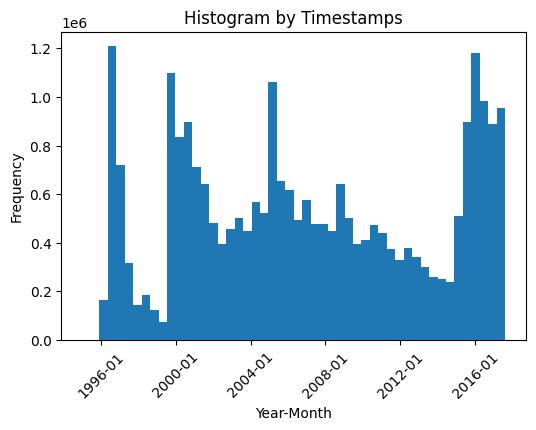

In [442]:
df_ratings_timestamp = pd.DataFrame()
df_ratings_timestamp['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(df_ratings_timestamp['timestamp'], bins=50)
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xlabel('Year-Month')
plt.ylabel('Frequency')
plt.title('Histogram by Timestamps')
plt.xticks(rotation=45)
plt.show()

---
### Dataset: ratings_small.csv

##### Data exploration

In [443]:
df_ratings_small = pd.read_csv("movies/ratings_small.csv")
df_ratings_small

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [444]:
# Data types of each column
df_ratings_small.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

##### Missing values

In [445]:
# Counting occurrences of missing values
missing_values = get_missing_values(df_ratings_small)
missing_values

,Column,Missing Count
0,userId,0
1,movieId,0
2,rating,0
3,timestamp,0


##### Duplicated IDs

In [446]:
relevant_cols = ['userId', 'movieId']
for col in  relevant_cols:
    print(f"Duplicated values in {col}:\n {df_ratings_small[col].duplicated().sum()}")

Duplicated values in userId:
 99333
Duplicated values in movieId:
 90938


##### Unique ratings

In [447]:
unique_ratings_small_values = df_ratings_small['rating'].unique()
unique_ratings_small_values

array([2.5, 3. , 2. , 4. , 3.5, 1. , 5. , 4.5, 1.5, 0.5])

In [448]:
print("Count of unique ratings:", len(unique_ratings_small_values))

Count of unique ratings: 10


##### Verify that all df_links_small is consistent with df_links

In [449]:
verify_subset(df_ratings_small, df_ratings)

False

In [450]:
df_ratings_small_missing_rows = get_missing_rows(df_ratings_small, df_ratings)
df_ratings_small_missing_rows

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


#### Column timestamp

In [451]:
df_ratings_small['timestamp'].min(), df_ratings_small['timestamp'].max()

(789652009, 1476640644)

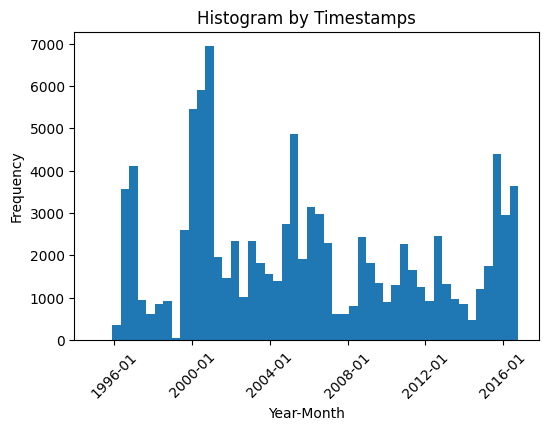

In [452]:
df_ratings_small_timestamp = pd.DataFrame()
df_ratings_small_timestamp['timestamp'] = pd.to_datetime(df_ratings_small['timestamp'], unit='s')

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(df_ratings_small_timestamp['timestamp'], bins=50)
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xlabel('Year-Month')
plt.ylabel('Frequency')
plt.title('Histogram by Timestamps')
plt.xticks(rotation=45)
plt.show()

In [453]:
df_credits.dtypes

cast    object
crew    object
id       int64
dtype: object

In [454]:
df_movies_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                   float64
genres                    object
homepage                  object
id                         Int64
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
collection_name           object
dtype: object

In [455]:
df_keywords.dtypes

id           int64
keywords    object
dtype: object

In [456]:
id = 862
k = df_credits[df_credits['id']==str(id)]

In [457]:
l = df_movies_metadata[df_movies_metadata['id']==str(id)]

In [458]:
k

,cast,crew,id


In [459]:
l

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,collection_name
